In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 4.2MB/s 


In [3]:
# Import required packages, libraries and classes for the project

import numpy as np
np.random.seed(1)

import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
import keras
plt.style.use('default')
from keras.layers import Dense, Dropout
import kerastuner as kt

### Data Preprocessing

In [4]:
# Load the Dataset
df = pd.read_csv("/content/drive/My Drive/stock8030.csv",parse_dates = True,index_col=0)
df.head()

,Open,High,Low,Volume,SMA,EMA,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH,STOCHD,Close
Date,,,,,,,,,,,,,,,
2014-06-15,32.5,32.8,32.4,482290.0,35.033333,35.273907,-2.1,24.189090,-13.793103,-2.032828,34.945,416347.233313,17.073171,18.031482,32.5
2014-06-16,32.5,32.8,32.4,673690.0,35.280952,35.551298,-2.0,24.385914,-14.435696,-2.039900,35.160,573695.586234,17.021277,19.916183,32.6
2014-06-17,32.6,32.9,31.8,604630.0,35.542857,35.846427,-2.4,24.966341,-14.322917,-2.029438,35.415,587012.596435,20.000000,16.806527,32.9
2014-06-18,32.9,34.1,32.9,1160000.0,35.804762,36.141070,-1.9,27.007018,-12.176166,-2.017111,35.675,331923.711053,22.727273,13.558664,33.9
2014-06-19,34.1,34.4,34.1,724030.0,36.028571,36.365177,-2.3,27.434139,-12.113402,-2.073856,35.900,151906.833214,7.692308,15.384615,34.1


In [5]:
# Correlation Matrix
df.corr()['Close']

Open       0.997722
High       0.998894
Low        0.998913
Volume     0.157783
SMA        0.966208
EMA        0.976025
MOM        0.154007
RSI        0.245332
ROC        0.227390
MACD       0.288514
BB         0.967934
CHAIKIN    0.503953
STOCH      0.109349
STOCHD     0.119068
Close      1.000000
Name: Close, dtype: float64

In [6]:
# Extracting the features for the LSTM model
series = df[["Close",	"MOM",	"RSI",	"ROC",	"MACD",	"BB",	"CHAIKIN",	"STOCH"]]
print(series.shape)
series.head()

(1460, 8)


,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH
Date,,,,,,,,
2014-06-15,32.5,-2.1,24.189090,-13.793103,-2.032828,34.945,416347.233313,17.073171
2014-06-16,32.6,-2.0,24.385914,-14.435696,-2.039900,35.160,573695.586234,17.021277
2014-06-17,32.9,-2.4,24.966341,-14.322917,-2.029438,35.415,587012.596435,20.000000
2014-06-18,33.9,-1.9,27.007018,-12.176166,-2.017111,35.675,331923.711053,22.727273
2014-06-19,34.1,-2.3,27.434139,-12.113402,-2.073856,35.900,151906.833214,7.692308


In [7]:
# Normalisation
sc_X = StandardScaler()
series.iloc[:,1:] = sc_X.fit_transform(series.iloc[:,1:])
sc_y = StandardScaler()
series[['Close']] = sc_y.fit_transform(series[['Close']])
series

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH
Date,,,,,,,,
2014-06-15,-0.121296,-0.372344,-2.289860,-0.807755,-1.042261,0.017282,-0.261939,-1.030382
2014-06-16,-0.115838,-0.355390,-2.273345,-0.839106,-1.045746,0.029196,-0.210433,-1.032087
2014-06-17,-0.099464,-0.423208,-2.224644,-0.833604,-1.040591,0.043327,-0.206074,-0.934240
2014-06-18,-0.044883,-0.338435,-2.053420,-0.728866,-1.034518,0.057735,-0.289574,-0.844653
2014-06-19,-0.033967,-0.406253,-2.017582,-0.725804,-1.062476,0.070203,-0.348500,-1.338530
...,...,...,...,...,...,...,...,...
2020-05-03,-1.004412,-0.921670,-2.123941,-1.443134,-0.523212,-0.808496,-0.019934,-1.497950
2020-05-04,-0.967298,-0.636835,-1.926685,-1.277607,-0.473482,-0.791096,0.161875,-1.145632
2020-05-05,-0.937824,-0.463899,-1.752243,-1.088202,-0.433304,-0.776411,0.181921,-1.117108


In [8]:
series.tail()

,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH
Date,,,,,,,,
2020-05-03,-1.004412,-0.921670,-2.123941,-1.443134,-0.523212,-0.808496,-0.019934,-1.497950
2020-05-04,-0.967298,-0.636835,-1.926685,-1.277607,-0.473482,-0.791096,0.161875,-1.145632
2020-05-05,-0.937824,-0.463899,-1.752243,-1.088202,-0.433304,-0.776411,0.181921,-1.117108
2020-05-06,-0.912717,-0.406253,-1.590857,-0.863410,-0.399481,-0.763499,0.285989,-0.913384
2020-05-07,-0.891976,-0.372344,-1.448884,-0.694138,-0.370541,-0.752971,0.441662,-0.828980


In [9]:
# Train/Test Data Split
train_start = dt.date(2014,5,15)
train_end = dt.date(2020,3,1)
train_data = series.loc[train_start:train_end]

test_start = dt.date(2020,3,2)
test_end = dt.date(2020,6,14)
test_data = series.loc[test_start:test_end]

print(train_data.shape,test_data.shape)

(1411, 8) (49, 8)


In [10]:
train = train_data.values
val = test_data.values

In [11]:
# Setting up an Early Stopping function
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]
RMSE = keras.metrics.RootMeanSquaredError()

In [12]:
#Build and train the model
def fit_model(train,val,timesteps,lr,batch,epochs,dropout,units):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
    hl = units
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error',
                  metrics=[RMSE,'mse', 'mae', 'mape'])
    #print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,
                        validation_data = (X_val, Y_val),verbose = 2,
                        shuffle = False, callbacks=callbacks_list)
    mse = history.history['val_mse'][-1]
    mae = history.history['val_mae'][-1]
    mape = history.history['val_mape'][-1]
    rmse = history.history["val_root_mean_squared_error"][-1]
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss'],\
     rmse, mse, mae, mape


In [13]:
X_train = []
Y_train = []
X_val = []
Y_val = []
timesteps = 45
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

# Loop for val data
for i in range(timesteps,val.shape[0]):
    X_val.append(val[i-timesteps:i])
    Y_val.append(val[i][0])
X_val,Y_val = np.array(X_val),np.array(Y_val)

In [14]:
from keras import backend as K
from keras.losses import mean_squared_error

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))

In [15]:
def model_builder(hp):
  # Define the ConvLSTM Model
  model = keras.Sequential()
  model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))

  # Tune the number of units in the first Dense layer
  hp_units = hp.Int('units', min_value = 16, max_value = 64, step = 8)
  model.add(LSTM(units = hp_units,activation = 'relu',return_sequences = True))
  model.add(LSTM(units = hp_units,activation = 'relu'))

  hp_dropout = hp.Float('dropout', min_value = .2, max_value = .5, step = .1)
  model.add(Dropout(rate = hp_dropout))
  model.add(Dense(1))
  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  hp_batch = hp.Choice('batch_size', values = [8,16,64])

  model.compile(optimizer = optimizers.Adam(learning_rate = hp_learning_rate),
                loss = root_mean_squared_error,
                metrics=[root_mean_squared_error,'mse', 'mae', 'mape'])
  
  return model


In [16]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 50,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')

In [17]:
import tensorflow as tf
import IPython
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [18]:
tuner.search(X_train, Y_train, epochs = 10, validation_data = (X_val, Y_val), callbacks = [ClearTrainingOutput()])


Trial 90 Complete [00h 01m 42s]
val_loss: 0.22317609190940857

Best val_loss So Far: 0.0051719993352890015
Total elapsed time: 00h 37m 31s
INFO:tensorflow:Oracle triggered exit


In [19]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete.\nThe optimal number of units in the first densely-connected layer is {best_hps.get('units')}\n
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}\n
The best dropout is {best_hps.get('dropout')}\n
The best batch size is {best_hps.get('batch_size')}\n
The best num of epochs is {best_hps.get('tuner/epochs')}.
""")


The hyperparameter search is complete.
The optimal number of units in the first densely-connected layer is 56

The optimal learning rate for the optimizer is 0.001

The best dropout is 0.4000000000000001

The best batch size is 64

The best num of epochs is 50.



In [20]:
tuner.results_summary(num_trials=90)

Results summary
Results in my_dir/intro_to_kt
Showing 90 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 56
dropout: 0.4000000000000001
learning_rate: 0.001
batch_size: 64
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 3c9f3b15230bcd8b7565844ad9a6e46b
Score: 0.0051719993352890015
Trial summary
Hyperparameters:
units: 64
dropout: 0.4000000000000001
learning_rate: 0.01
batch_size: 64
tuner/epochs: 6
tuner/initial_epoch: 2
tuner/bracket: 3
tuner/round: 1
tuner/trial_id: af98c41ca74855600ec4eb358f7759c4
Score: 0.0058720409870147705
Trial summary
Hyperparameters:
units: 32
dropout: 0.30000000000000004
learning_rate: 0.0001
batch_size: 8
tuner/epochs: 17
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.006891354918479919
Trial summary
Hyperparameters:
units: 64
dropout: 0.2
learning_rate: 0.001
batch_size: 8
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 2
tuner/round: 1
tuner/trial

In [21]:
model = tuner.hypermodel.build(best_hps)
model.fit(X_train, Y_train, epochs = 50, validation_data = (X_val, Y_val))

Epoch 1/50
43/43 [==============================] - 5s 55ms/step - loss: 0.6869 - root_mean_squared_error: 0.6869 - mse: 0.6747 - mae: 0.6869 - mape: 95.4809 - val_loss: 0.2181 - val_root_mean_squared_error: 0.2181 - val_mse: 0.0477 - val_mae: 0.2181 - val_mape: 23.5000
Epoch 2/50
43/43 [==============================] - 2s 45ms/step - loss: 0.2203 - root_mean_squared_error: 0.2203 - mse: 0.0887 - mae: 0.2203 - mape: 63.5553 - val_loss: 0.0794 - val_root_mean_squared_error: 0.0794 - val_mse: 0.0064 - val_mae: 0.0794 - val_mape: 8.6066
Epoch 3/50
43/43 [==============================] - 2s 46ms/step - loss: 0.1873 - root_mean_squared_error: 0.1873 - mse: 0.0613 - mae: 0.1873 - mape: 47.4017 - val_loss: 0.0843 - val_root_mean_squared_error: 0.0843 - val_mse: 0.0072 - val_mae: 0.0843 - val_mape: 9.1270
Epoch 4/50
43/43 [==============================] - 2s 47ms/step - loss: 0.1843 - root_mean_squared_error: 0.1843 - mse: 0.0601 - mae: 0.1843 - mape: 42.7617 - val_loss: 0.0104 - val_root_m

In [22]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Close')
    plt.title('Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [23]:
# Plotting the training errors
def plot_loss(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

In [24]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    
    # Prediction Time 
    Y_hat = model.predict(X_test)
    return Y_test, Y_hat

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 45, 8)             544       
_________________________________________________________________
lstm_1 (LSTM)                (None, 45, 56)            14560     
_________________________________________________________________
lstm_2 (LSTM)                (None, 56)                25312     
_________________________________________________________________
dropout (Dropout)            (None, 56)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 57        
Total params: 40,473
Trainable params: 40,473
Non-trainable params: 0
_________________________________________________________________


In [26]:
y_pred = model.predict(X_val)
y_true = np.array([Y_val]).T

mae = tf.keras.losses.MeanAbsoluteError()
mae = mae(y_true, y_pred).numpy()

mape = tf.keras.losses.MeanAbsolutePercentageError()
mape = mape(y_true, y_pred).numpy()

mse = tf.keras.losses.MeanSquaredError()
mse = mse(y_true, y_pred).numpy()

rmse = sqrt(mse)

In [33]:
print('MSE = {}'.format(round(mse, 5)))
print('RMSE = {}'.format(round(rmse, 5)))
print('MAPE = {}'.format(round(mape, 5)))
print('MAE = {}'.format(round(mae, 5)))

MSE = 0.004019999876618385
RMSE = 0.06341
MAPE = 6.715519905090332
MAE = 0.061810001730918884


In [28]:
true,predicted = evaluate_model(model,val,timesteps)

In [29]:
train_date = df['2014-05-15' : '2020-03-1'].index
test_date = df['2020-03-2' :].index
pred_date = df['2020-03-2' :].index[45:]

In [30]:
Y_train = sc_y.inverse_transform(np.array([train[:,0]]))
Y_test = sc_y.inverse_transform(np.array([val[:,0]]))
Y_pred = sc_y.inverse_transform(predicted.T)

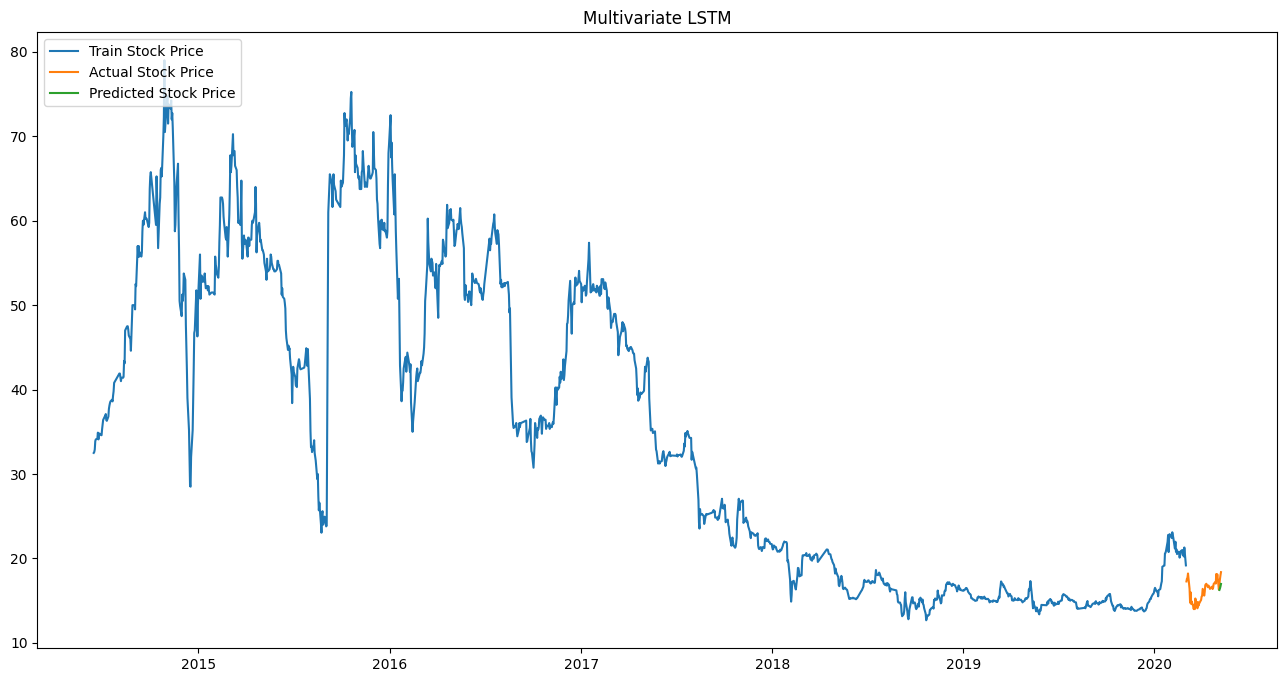

In [31]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates

plt.figure(figsize=(16,8))
price_close_train = Y_train[0]
price_close_test = Y_test[0]
plt.plot(train_date, price_close_train, label = "Train Stock Price")
plt.plot(test_date, price_close_test, label = "Actual Stock Price")
plt.plot(pred_date, Y_pred[0], label = "Predicted Stock Price")

plt.title("Multivariate LSTM")
plt.legend(loc='upper left')
#plt.tight_layout()

plt.show()

In [32]:
# Save a model
model.save('MV-LSTM_dataset3_hyperband.h5')